In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
import os

In [0]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [0]:
learning_rate= 2e-4
batch_size = 100
num_epochs = 20
n_noise = 100

In [0]:
sample_dir = 'samples'

if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.MNIST(root='../../data/', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8036246.50it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134112.43it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2134546.92it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 47872.32it/s]            


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False), 
                                nn.BatchNorm2d(64), # (n, 64, 14, 14)
                                nn.ReLU(True),
                                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(128), # (n, 128, 7, 7)
                                nn.ReLU(True),
                                nn.Conv2d(128, 256, kernel_size =3, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(256), # (n, 256, 4, 4)
                                nn.ReLU(True),
                                nn.AvgPool2d(4))
    
    self.fc = nn.Sequential(nn.Linear(256,1),
                            nn.Sigmoid())
    
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    
    return out
  
  
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.layer1 = nn.Linear(n_noise, 256*4*4)
    
    self.convT = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 1, 0), 
                              nn.BatchNorm2d(128),  # (n, 128, 7, 7)
                              nn.LeakyReLU(0.2, True),
                              nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                              nn.BatchNorm2d(64),   # (n, 64, 14, 14)
                              nn.LeakyReLU(0.2, True),
                              nn.ConvTranspose2d(64, 1, 4, 2, 1),   
                              nn.Tanh())            # (n, 1, 28, 28) 
    
  def forward(self, x):
    out = self.layer1(x)
    
    out = out.view(out.size(0), 256, 4, 4)
    out = self.convT(out)
    return out

In [0]:
D = Discriminator().to(device)
G = Generator().to(device)

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

def zero_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()
  
def norm(images):
  return images*2 - 1
  
def denorm(images):
  images = (images+1) / 2
  return images.clamp(0,1)


In [9]:
for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
    images = images.to(device)
    images = norm(images)
    
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)
    #===================================================
    #                 Train Discriminator
    # ==================================================
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z)
    outputs = D(fake_image)
    d_loss_fake = criterion(outputs, fake_labels)
    
    
    d_loss = d_loss_real + d_loss_fake
    
    zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    #===================================================
    #                 Train Generator
    # ==================================================
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z)
    outputs_fake = D(fake_image)
    g_loss = criterion(outputs_fake, real_labels)
    
    zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    
    if (i+1) % 200 == 0:
      print('Epoch [{}/{}], Step [{}/{}], d_loss {:.4f}, g_loss : {:.4f}'
            .format(epoch, num_epochs, i+1, len(data_loader), d_loss.item(), g_loss.item()))

    
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  save_image(denorm(fake_image), os.path.join(sample_dir, 'fake_images={}.png'.format(str(epoch).zfill(2))))

Epoch [0/20], Step [200/600], d_loss 0.6713, g_loss : 1.2155
Epoch [0/20], Step [400/600], d_loss 0.3163, g_loss : 1.9528
Epoch [0/20], Step [600/600], d_loss 0.3374, g_loss : 1.8241
Epoch [1/20], Step [200/600], d_loss 0.1965, g_loss : 2.3952
Epoch [1/20], Step [400/600], d_loss 0.2188, g_loss : 2.3181
Epoch [1/20], Step [600/600], d_loss 0.1961, g_loss : 2.2199
Epoch [2/20], Step [200/600], d_loss 0.1722, g_loss : 2.8748
Epoch [2/20], Step [400/600], d_loss 0.1308, g_loss : 2.9564
Epoch [2/20], Step [600/600], d_loss 0.0818, g_loss : 2.5200
Epoch [3/20], Step [200/600], d_loss 0.2403, g_loss : 2.2032
Epoch [3/20], Step [400/600], d_loss 0.2487, g_loss : 2.0210
Epoch [3/20], Step [600/600], d_loss 0.5632, g_loss : 2.4171
Epoch [4/20], Step [200/600], d_loss 0.2828, g_loss : 2.3414
Epoch [4/20], Step [400/600], d_loss 0.3549, g_loss : 2.4552
Epoch [4/20], Step [600/600], d_loss 0.2746, g_loss : 1.6154
Epoch [5/20], Step [200/600], d_loss 0.3723, g_loss : 2.4689
Epoch [5/20], Step [400/

In [0]:
from matplotlib.pyplot import imshow, imsave
import numpy as np
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        z = torch.randn(10, n_noise).to(device)
        y_hat = G(z).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

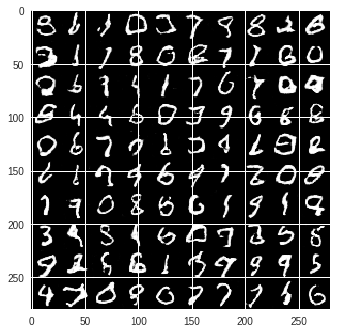

In [11]:
imshow(get_sample_image(G, n_noise), cmap='gray')